In [102]:
import numpy as np
import xarray as xr
import seaborn as sns
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib.patches import Ellipse
import matplotlib.ticker as mtick
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from functools import reduce
plt.rcParams.update({'font.size': 15})

from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection


In [13]:
#Some graphics resources 
def hex_to_rgb(value):
    '''
    Converts hex to rgb colours
    value: string of 6 characters representing a hex colour.
    Returns: list length 3 of RGB values'''
    value = value.strip("#") # removes hash symbol if present
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))


def rgb_to_dec(value):
    '''
    Converts rgb to decimal colours (i.e. divides each value by 256)
    value: list (length 3) of RGB values
    Returns: list (length 3) of decimal values'''
    return [v/256 for v in value]


def get_continuous_cmap(hex_list, float_list=None):
    ''' creates and returns a color map that can be used in heat map figures.
        If float_list is not provided, colour map graduates linearly between each color in hex_list.
        If float_list is provided, each color in hex_list is mapped to the respective location in float_list. 
        
        Parameters
        ----------
        hex_list: list of hex code strings
        float_list: list of floats between 0 and 1, same length as hex_list. Must start with 0 and end with 1.
        
        Returns
        ----------
        colour map'''
    rgb_list = [rgb_to_dec(hex_to_rgb(i)) for i in hex_list]
    if float_list:
        pass
    else:
        float_list = list(np.linspace(0,1,len(rgb_list)))
        
    cdict = dict()
    for num, col in enumerate(['red', 'green', 'blue']):
        col_list = [[float_list[i], rgb_list[i][num], rgb_list[i][num]] for i in range(len(float_list))]
        cdict[col] = col_list
    cmp =LinearSegmentedColormap('my_cmp', segmentdata=cdict, N=256)
    return cmp

x, y = np.mgrid[-5:5:0.05, -5:5:0.05]
z = (np.sqrt(x**2 + y**2) + np.sin(x**2 + y**2))
hex_list = ["#fffcf2","#ccc5b9","#403d39","#252422","#eb5e28"]
hex_list =["#ffffff","#faf0ca","#f4d35e","#ee964b","#f95738","#eb5e28"]

hex_list =["#ffffff","#84dcc6","#a5ffd6","#f4d35e","#ffa69e","#ff686b","#eb5e28"]
hex_list =["#ffffff","#fffcf2","#84dcc6","#a5ffd6","#f4d35e","#ffa69e","#ff686b","#eb5e28"]
my_col=get_continuous_cmap(hex_list, float_list=None)

Define the FOPI 

In [3]:
def _fopi(x,y,F, a,b,x0,y0):
    arr = np.zeros(x.shape)
    print(x.shape)
   # arr = F*np.exp( -((x-x0)/a)**4 -((y-y0)/b)**4)  
    arr = F*np.exp( -((x-x0)/a)**4 ) *np.exp( -((y-y0)/b)**4 ) 
    return arr


Best fit parameters (see paper)

In [4]:
F,a,b,x0,y0=1. , 0.56716912 ,3.11504565 ,0.64580504 ,5.47653683 

In [5]:
data_dir='/perm/nen/2020_fire_datacube/'

In [219]:
biomes=xr.open_dataset("~/scripts/efi/biomes_grouped_50km.nc")
#fire activity
af=xr.open_dataset(data_dir+"activefire_2020_50km.nc")
ba=xr.open_dataset(data_dir+"2020-C3S-L4_FIRE-BA-OLCI-fv1.1_50km.nc")
#vegetation 
vod=xr.open_dataset(data_dir+"2020_VOD_runmean5_50km_timeint.nc")
lai=xr.open_dataset(data_dir+"CGLS_LAI_v2_2020_daily_50km.nc")
#Fire weather indices 
fwi=xr.open_dataset(data_dir+"FWI_2020_50km.nc")
fopi=xr.open_dataset(data_dir+'FOPI_2020_vod_ba.nc')

In [220]:
#reorder 
vod.coords['lon'] = (vod.coords['lon'] + 180) % 360 - 180
vod = vod.sortby(vod.lon)
lai.coords['lon'] = (lai.coords['lon'] + 180) % 360 - 180
lai = np.log(lai.sortby(lai.lon))
fwi.coords['lon'] = (fwi.coords['lon'] + 180) % 360 - 180
fwi = fwi.sortby(fwi.lon)
fopi.coords['lon'] = (fopi.coords['lon'] + 180) % 360 - 180
fopi = fopi.sortby(fopi.lon)
af.coords['lon'] = (af.coords['lon'] + 180) % 360 - 180
af = af.sortby(af.lon)
ba.coords['lon'] = (ba.coords['lon'] + 180) % 360 - 180
ba = ba.sortby(ba.lon)

/usr/local/apps/python3/3.8.8-01/lib/python3.8/site-packages/xarray/core/computation.py:724: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)


In [125]:
#set the world and the geometry 

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
cities = gpd.read_file(gpd.datasets.get_path('naturalearth_cities'))
# Reproject to Mercator (after dropping Antartica)
world = world[(world.name != "Antarctica") & (world.name != "Fr. S. Antarctic Lands")]
world = world.to_crs("EPSG:3857") # world.to_crs(epsg=3395) would also work
#check
#ax=world.plot(color='none', edgecolor='black',facecolor="none")
#ax.set_title("Mercator");
crs=world.crs



In [128]:
cities

,name,geometry
0,Vatican City,POINT (12.45339 41.90328)
1,San Marino,POINT (12.44177 43.93610)
2,Vaduz,POINT (9.51667 47.13372)
3,Luxembourg,POINT (6.13000 49.61166)
4,Palikir,POINT (158.14997 6.91664)
...,...,...
197,Cairo,POINT (31.24802 30.05191)
198,Tokyo,POINT (139.74946 35.68696)
199,Paris,POINT (2.33139 48.86864)
200,Santiago,POINT (-70.66899 -33.44807)


In [259]:
my_regions={'US-California':[-124.40,-114.13,32.53 ,42.00,np.Datetime64('2020-08-16','D')],
            'EU-Med':[-9.05,24.08,35.10,44.08,np.Datetime64('2020-02-16','D')],
            'AS-Artic':[32,172,55,75,np.Datetime64('2020-07-01','D')],
            'AU-NewSouthWales': [140.88,155.01,-37.57,-28.65,np.Datetime64('2020-01-04','D')],
       #    'West Africa':[-20,35,5,13],
            'US-Arizona':[-114.81,-109.045,31.33217,37.0042,np.Datetime64('2020-06-05','D')]}
nr=len(my_regions)


US-California
EU-Med
AS-Artic
AU-NewSouthWales
US-Arizona


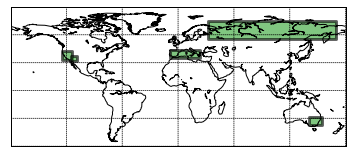

In [258]:



# Make the figure
fig = plt.figure()
ax = fig.add_subplot(111)

m = Basemap(projection='cyl',llcrnrlat=-60,urcrnrlat=90,\
            llcrnrlon=-180,urcrnrlon=180,resolution='c')
m.drawcoastlines()
#m.fillcontinents()
# draw parallels and meridians.
m.drawparallels(np.arange(-90.,91.,30.))
m.drawmeridians(np.arange(-180.,181.,60.))
m.drawmapboundary()

# Fill two polygon shapes
patches = []

for key in my_regions:
    print(key)
    lon1=my_regions[key][0]
    lon2=my_regions[key][1]
    lat1=my_regions[key][2]
    lat2=my_regions[key][3]
    pol = np.array([[lon1,lat1],[lon1,lat2],[lon2,lat2],[lon2,lat1]])
    patches.append(Polygon(pol))

ax.add_collection(PatchCollection(patches, facecolor='tab:green', alpha=0.6,edgecolor='k', linewidths=3))

plt.show()


Time series of the events 

US-California


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


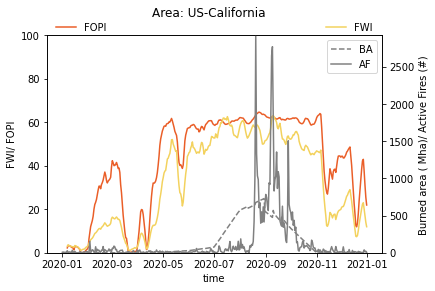

EU-Mediteranium


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


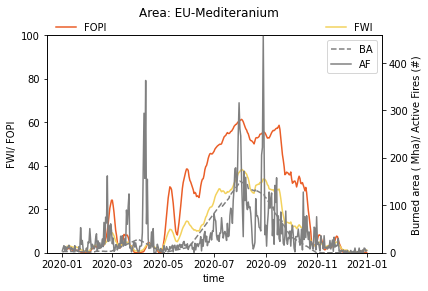

AS-Artic


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


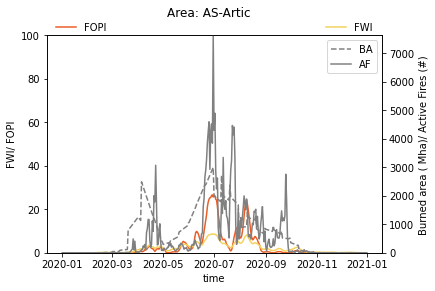

AU-New South Wales


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


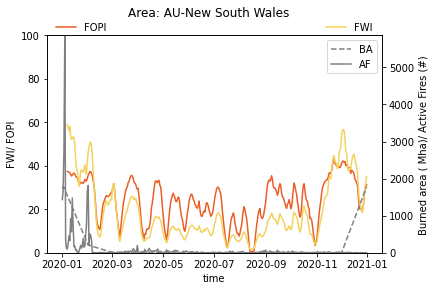

US-Arizona


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


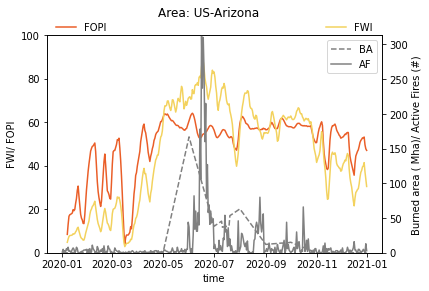

In [11]:

for key in my_regions:
    print(key)
    lon1=my_regions[key][0]
    lon2=my_regions[key][1]

    lat1=my_regions[key][2]
    lat2=my_regions[key][3]
    day=my_regions[key][4]
    dfwi= fwi.fwi.sel(lat=slice(lat1,lat2),lon=slice(lon1,lon2)).to_dataframe().reset_index()
    dfopi= fopi.fopi.sel(lat=slice(lat1,lat2),lon=slice(lon1,lon2)).to_dataframe().reset_index()
    dvod= vod.SM_IDW.sel(lat=slice(lat1,lat2),lon=slice(lon1,lon2)).to_dataframe().reset_index()
    daf=af.var98.sel(lat=slice(lat1,lat2),lon=slice(lon1,lon2)).to_dataframe().reset_index()
    dba=ba.burned_area.sel(lat=slice(lat1,lat2),lon=slice(lon1,lon2)).to_dataframe().reset_index()
    dlai= lai.LAI.sel(lat=slice(lat1,lat2),lon=slice(lon1,lon2)).to_dataframe().reset_index()
    dfwi['date'] = pd.to_datetime(dfwi['time']).dt.date
    dvod['date'] = pd.to_datetime(dvod['time']).dt.date
    daf['date'] = pd.to_datetime(daf['time']).dt.date
    dba['date'] = pd.to_datetime(dba['time']).dt.date
    dlai['date'] = pd.to_datetime(dlai['time']).dt.date
    dfopi['date'] = pd.to_datetime(dfopi['time']).dt.date
    
    data_frame=[dfwi,dvod,daf,dba,dlai,dfopi]
 #  print(data_frame)   
    df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['date','lat','lon'], how='outer'), data_frame).dropna()
    #time series dataframe 
    ts=pd.DataFrame()
    # we need some strategy to extract information over the areas 
    # we will add all the burned areas and active fires
    # we will considere the median for the FWI and FOPI 
    
    tmp=df_merged.groupby(['date'])['burned_area'].sum().reset_index()
    ts['date']=pd.to_datetime(tmp['date']).dt.date
    # total of burned areas ove the region 
    ts['ba']=tmp['burned_area']
    
    # FWI 
    tmp=df_merged.groupby(['date'])['fwi'].median().reset_index()
    ts['fwi']=tmp['fwi']
    # fopi
    tmp=df_merged.groupby(['date'])['fopi'].median().reset_index()
    ts['fopi']=tmp['fopi']
    # active fire we sum 
    tmp=df_merged.groupby(['date'])['var98'].sum().reset_index()
    ts['af']=(tmp['var98'])

     # extrast   
    #tmp=df_merged.groupby(['date'])['LAI'].mean().reset_index()
    #ts['lai']=(tmp['LAI'])
    # tmp=df_merged.groupby(['date'])['SM_IDW'].median().reset_index()
    # ts['vod']=tmp['SM_IDW']
    # time is the index 
    ts=ts.set_index(ts['date'])

    a=ts.fwi.rolling(7).mean()
    a.loc[a<=1]=1

    fig, ax1 = plt.subplots()

    fig.suptitle('Area: '+key)
    color1 = 'tab:red'
    ax1.set_xlabel('time')
    ax1.set_ylabel('FWI/ FOPI', color='black')
    ax1.plot( 100*ts.fopi.rolling(7).mean(), color=rgb_to_dec(hex_to_rgb(hex_list[7])))
    ax1.plot( ts.fwi.rolling(7).mean(), color=rgb_to_dec(hex_to_rgb(hex_list[4])))
   # ax1.axhline(0.5, color=rgb_to_dec(hex_to_rgb(hex_list[4])))
   # ax1.text(ts.index[0],10,'FWI=10',rotation=0)

   # ax1.axhline(1, color=rgb_to_dec(hex_to_rgb(hex_list[4])))
   # ax1.text(ts.index[0],20,'FWI=20',rotation=0)
   # ax1.axhline(2, color=rgb_to_dec(hex_to_rgb(hex_list[4])))
   # ax1.text(ts.index[0],40,'FWI=40',rotation=0)
    #ax1.tick_params(axis='y', labelcolor='black')
    #plt.yticks(np.arange(0, 600, step=100))
    plt.ylim([0, 100])
    plt.legend(['FOPI','FWI'], bbox_to_anchor=(0,0.9,1,0.2),loc='upper center', frameon=False,mode='expand',ncol=2)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    #color = 'tab:green'
    ax2.set_ylabel('Burned area ( Mha)/ Active Fires (#)', color='black')  # we already handled the x-label with ax1
    ax2.plot(ts.ba/1000, color='gray',linestyle='dashed')
    ax2.plot(ts.af, color='gray',linestyle='solid')
    #ax2.tick_params(axis='y', labelcolor='black')
    #plt.yticks(np.arange(0, 100, step=10))
    plt.ylim([0, max(ts.af)])
    plt.legend(['BA','AF'], loc='upper right')
    plt.savefig('/home/nen/scripts/plots/'+key, format='eps', bbox_inches='tight', dpi=600, pad_inches=1.0)
    plt.show()

Simpler version using wordmap

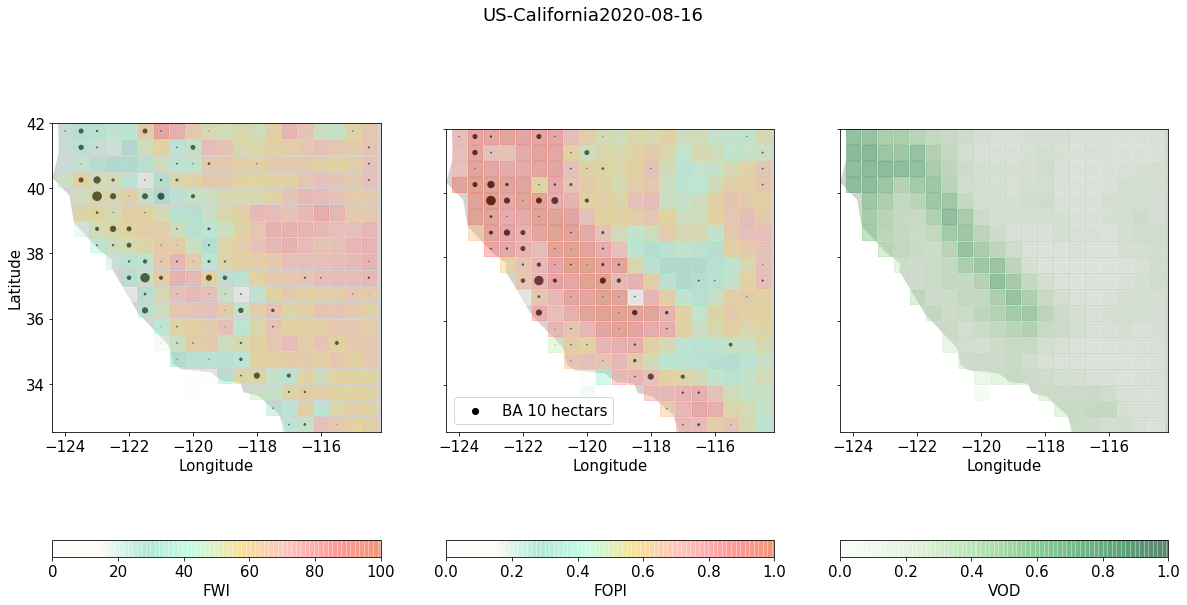

<Figure size 432x288 with 0 Axes>

In [129]:
key='US-California'
#key='US-Arizona'
#key='AU-NewSouthWales'
lon1=my_regions[key][0]
lon2=my_regions[key][1]

lat1=my_regions[key][2]
lat2=my_regions[key][3]
day=my_regions[key][4]
#day=np.Datetime64('2020-08-10','D')
day
dfwi=fwi.fwi.sel(lat=slice(lat1,lat2),lon=slice(lon1,lon2),time=slice(day,day+1)).to_dataframe().reset_index()
dfopi=fopi.fopi.sel(lat=slice(lat1,lat2),lon=slice(lon1,lon2),time=slice(day,day+1)).to_dataframe().reset_index()
daf=af.var98.sel(lat=slice(lat1,lat2),lon=slice(lon1,lon2),time=slice(day,day+1)).to_dataframe().reset_index()
dvod= vod.SM_IDW.sel(lat=slice(lat1,lat2),lon=slice(lon1,lon2),time=slice(day,day+1)).to_dataframe().reset_index()
dba=ba.burned_area.sel(lat=slice(lat1,lat2),lon=slice(lon1,lon2),time=slice(day,day+1)).to_dataframe().reset_index()



dfwi['date'] = pd.to_datetime(dfwi['time']).dt.date
dfopi['date'] = pd.to_datetime(dfopi['time']).dt.date
daf['date'] = pd.to_datetime(daf['time']).dt.date
dvod['date'] = pd.to_datetime(dvod['time']).dt.date
dba['date'] = pd.to_datetime(dba['time']).dt.date

data_frame=[dfwi,dfopi,daf,dvod,dba]

 #  print(data_frame)   
df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['date','lat','lon'], how='outer'), 
                   data_frame).dropna().drop(columns=['time_x','time_y'])


# Creating axes and plotting world map

fig, axs = plt.subplots(1, 3, sharex='col', sharey='row',figsize=(20,10))
fig.suptitle(key + str(day))



worldmap.plot(color="lightgrey", ax=axs[0])
cities.plot(color="lightgrey", ax=axs[0])
worldmap.plot(color="lightgrey", ax=axs[1])
worldmap.plot(color="lightgrey", ax=axs[2])

m = Basemap(projection='lcc', resolution='h')
m.shadedrelief()
m.drawcoastlines(color='gray')
m.drawcountries(color='gray')
m.drawstates(color='gray')

# Plotting FWI
x = df_merged['lon']
y = df_merged['lat']
z = df_merged['fwi']

plt1=axs[0].scatter(x, y,df_merged['burned_area']/1000.,marker='o',alpha=1,
            c='black')

plt1=axs[0].scatter(x, y,s=200, c=z, marker='s',alpha=0.4, vmin=0, vmax=100,
           cmap=my_col)
#axs[0].colorbar(label='FWI')
# Creating axis for plot1 
axs[0].set_xlim([lon1, lon2])
axs[0].set_ylim([lat1, lat2])
axs[0].set_xlabel("Longitude")
axs[0].set_ylabel("Latitude")
plt.colorbar(plt1,ax=axs[0],label='FWI',orientation="horizontal", pad=0.2)

# Plotting FOPI
z1 = df_merged['fopi']
plt1=axs[1].scatter(x, y,df_merged['burned_area']/1000.,marker='o',alpha=1,
            c='black', label='BA 10 hectars')
axs[1].legend()
plt2=axs[1].scatter(x, y,s=200, c=z1, marker='s',alpha=0.4, vmin=0, vmax=1,
           cmap=my_col)
# Creating axis for plot2
axs[1].set_xlim([lon1, lon2])
axs[1].set_ylim([lat1, lat2])
axs[1].set_xlabel("Longitude")
#axs[1].set_ylabel("Latitude")
plt.colorbar(plt2,ax=axs[1],label='FOPI',orientation="horizontal", pad=0.2)
# Plotting VOD 

z1 = df_merged['SM_IDW']

plt3=axs[2].scatter(x, y,s=200, c=z1, marker='s',alpha=0.4, vmin=0, vmax=1,
           cmap='Greens')
# Creating axis for plot2
axs[2].set_xlim([lon1, lon2])
axs[2].set_ylim([lat1, lat2])
axs[2].set_xlabel("Longitude")
#axs[2].set_ylabel("Latitude")
plt.colorbar(plt3,ax=axs[2],label='VOD',orientation="horizontal", pad=0.2)




plt.show()




#df_geop= gpd.GeoDataFrame(df_merged,   geometry=gpd.points_from_xy(df_merged.lon, df_merged.lat),
     #                          crs=world.crs)
#df_geop
#ignition_gdf = ignition_gdf.rename({'STRF': 'Biome'}, axis=1)  # new method

plt.savefig('/home/nen/scripts/plots/map_fopi'+key, format='eps', bbox_inches='tight', dpi=600, pad_inches=1.0)
plt.show()

More complex version using basemap (then you can have nice openstreet background mayeb no worth it as we have contouring )

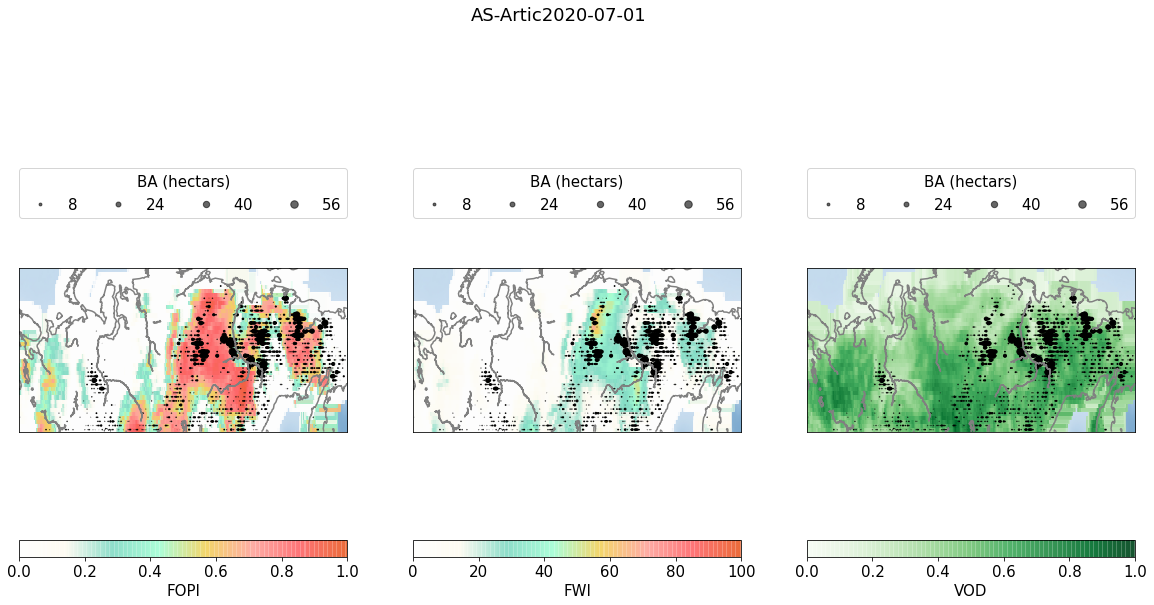

In [295]:


#key='US-California'
#key='US-Arizona'
#key='AU-NewSouthWales'
#key='EU-Med'
key='AS-Artic'
lon1=my_regions[key][0]
lon2=my_regions[key][1]

lat1=my_regions[key][2]
lat2=my_regions[key][3]
day=my_regions[key][4]
#day=np.Datetime64('2020-08-10','D')
day
dfwi=fwi.fwi.sel(lat=slice(lat1,lat2),lon=slice(lon1,lon2),time=slice(day,day+1)).to_dataframe().reset_index()
dfopi=fopi.fopi.sel(lat=slice(lat1,lat2),lon=slice(lon1,lon2),time=slice(day,day+1)).to_dataframe().reset_index()
daf=af.var98.sel(lat=slice(lat1,lat2),lon=slice(lon1,lon2),time=slice(day,day+1)).to_dataframe().reset_index()
dvod= vod.SM_IDW.sel(lat=slice(lat1,lat2),lon=slice(lon1,lon2),time=slice(day,day+1)).to_dataframe().reset_index()
dba=ba.burned_area.sel(lat=slice(lat1,lat2),lon=slice(lon1,lon2),time=slice(day,day+1)).to_dataframe().reset_index()

dfwi['date'] = pd.to_datetime(dfwi['time']).dt.date
dfopi['date'] = pd.to_datetime(dfopi['time']).dt.date
daf['date'] = pd.to_datetime(daf['time']).dt.date
dvod['date'] = pd.to_datetime(dvod['time']).dt.date
dba['date'] = pd.to_datetime(dba['time']).dt.date

data_frame=[dfwi,dfopi,daf,dvod,dba]

 #  print(data_frame)   
df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['date','lat','lon'], how='outer'), 
                   data_frame).dropna().drop(columns=['time_x','time_y'])


# Creating axes and plotting world map

fig, axs = plt.subplots(1, 3, sharex='col', sharey='row',figsize=(20,10))
fig.suptitle(key + str(day))


from mpl_toolkits.basemap import Basemap
# Lambert Conformal Conic map.

def my_map (axpl,lat1,lat2,lon1,lon2) :
    m = Basemap(projection='cyl', resolution='l',
                llcrnrlat=lat1, urcrnrlat=lat2,llcrnrlon=lon1, urcrnrlon=lon2,ax=axpl)
    m.shadedrelief(zorder=0)
    #m.etopo()
   # m.drawcountries(color='gray')
    #m.drawlsmask(land_color='0.8', ocean_color='blue', lsmask=None, lsmask_lons=None, lsmask_lats=None, lakes=True, resolution='l', grid=5)
    #m.fillcontinents(color='yellow', lake_color='blue', ax=None, zorder=0, alpha=None)
    #m.drawstates(color='gray')
    m.drawcoastlines(linewidth=1.5,color='gray')
    m.drawcountries()
    #m.drawmapboundary(fill_color='#99ffff')
   # m.fillcontinents(color='#cc9966',lake_color='#99ffff', zorder=0)
    #m.drawparallels(np.arange(lat1,lat2,3),labels=[1,0,0,0],fmt='%.0f')
    #m.drawmeridians(np.arange(lon1,lon2,3),labels=[1,1,1,0],fmt='%.0f') 
    # artic 
    #m.drawparallels(np.arange(lat1,lat2,10),labels=[1,0,0,0],fmt='%.0f')
    #m.drawmeridians(np.arange(lon1,lon2,60),labels=[1,1,1,0],fmt='%.0f') 
    return m

def forceAspect(ax,aspect=1):
    im = ax.get_images()
    extent =  im[0].get_extent()
    ax.set_aspect(abs((extent[1]-extent[0])/(extent[3]-extent[2]))/aspect)



 
    
m=my_map(axs[0],lat1,lat2,lon1,lon2)


# Plotting FWI
x = df_merged['lon']
y = df_merged['lat']
z = df_merged['fopi']

# FOPI
firedanger=m.scatter(x, y,s=400, c=z, marker='s',alpha=0.7, vmin=0, vmax=1,
           cmap=my_col,ax=axs[0],zorder=1)

baplot=axs[0].scatter(x, y,df_merged['burned_area']/1000.,marker='o',alpha=1,
            c='black')
# produce a legend with a cross section of sizes from the scatter
handles, labels = baplot.legend_elements(prop="sizes", alpha=0.6)
axs[0].legend(handles[::2], labels[::2],  title="BA (hectars)",bbox_to_anchor=(0, 1.3, 1, 0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=4)
plt.colorbar(firedanger,label='FOPI',orientation="horizontal", pad=0.2,ax=axs[0])

# FWI
m=my_map(axs[1],lat1,lat2,lon1,lon2)
z = df_merged['fwi']

firedanger=m.scatter(x, y,s=400, c=z, marker='s',alpha=0.7, vmin=0, vmax=100,
           cmap=my_col,ax=axs[1],zorder=1)

baplot=axs[1].scatter(x, y,df_merged['burned_area']/1000.,marker='o',alpha=1,
            c='black')
# produce a legend with a cross section of sizes from the scatter
handles, labels = baplot.legend_elements(prop="sizes", alpha=0.6)
axs[1].legend(handles[::2], labels[::2],  title="BA (hectars)",bbox_to_anchor=(0, 1.3, 1, 0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=4)
plt.colorbar(firedanger,label='FWI',orientation="horizontal", pad=0.2,ax=axs[1])

#VOD
m=my_map(axs[2],lat1,lat2,lon1,lon2)
z = df_merged['SM_IDW']

firedanger=m.scatter(x, y,s=400, c=z, marker='s',alpha=0.7, vmin=0, vmax=1,
           cmap='Greens',ax=axs[2],zorder=1)

baplot=axs[2].scatter(x, y,df_merged['burned_area']/1000.,marker='o',alpha=1,
            c='black')
# produce a legend with a cross section of sizes from the scatter
handles, labels = baplot.legend_elements(prop="sizes", alpha=0.6)
axs[2].legend(handles[::2], labels[::2],  title="BA (hectars)",bbox_to_anchor=(0, 1.3, 1, 0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=4)

plt.colorbar(firedanger,label='VOD',orientation="horizontal", pad=0.2,ax=axs[2])

forceAspect(axs[0],aspect=2)
forceAspect(axs[1],aspect=2)
forceAspect(axs[2],aspect=2)

plt.savefig('/home/nen/scripts/plots/map_fopi'+key+'.svg', format='svg', bbox_inches='tight', dpi=600, pad_inches=1.0)
plt.show()